In [298]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

from datasets import load_dataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [299]:
sequence_len = 32
embedding_dim = 256
n_heads = 8

**Make dataset**

In [308]:
books = load_dataset("opus_books", "en-fr")
books = books["train"].train_test_split(test_size=0.2)

# French to English
train_data = books["train"]
test_data = books["test"]

train_size = len(train_data)
test_size = len(test_data)

def choose_data(min_len, max_len):
    train_input_L = []
    train_output_L = []
    train_input = []
    train_output = []

    # use smaller data
    print("Making dataset...")
    for i in tqdm(range(train_size)):
        if min_len <= len(train_data[i]['translation']['fr']) <= max_len and min_len <= len(train_data[i]['translation']['en']) <= max_len:
            train_input.append(train_data[i]['translation']['fr'])
            train_output.append(train_data[i]['translation']['en'])
            train_input_L.append(len(train_input[-1]) + 2)  # We will add a begin token
            train_output_L.append(len(train_output[-1]) + 2)
    return len(train_input), train_input, train_output, train_input_L, train_output_L
        
# 127 because we will add a begin token
train_size, train_input, train_output, train_input_L, train_output_L = choose_data(0, sequence_len-2)

print(train_size)


Making dataset...


  0%|          | 0/101668 [00:00<?, ?it/s]

8808


In [311]:
print(sorted(train_input_L))

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

#**Make Embedding**

In [312]:
def tokenize_and_embedding(train_input, train_output, train_input_L, train_output_L):
    train_size = len(train_input)
    ####################  record tokens ####################
    input_TokenList = {"padding", "begin", "end"}
    input_TokenList = input_TokenList.union(*train_input)
    input_TokenList = list(input_TokenList)
    output_TokenList = {"padding", "begin", "end"}
    output_TokenList = output_TokenList.union(*train_output)
    output_TokenList = list(output_TokenList)
    
    ####################  make embedding table ####################
    input_embedding_table = {}
    for token in input_TokenList:
        input_embedding_table[token] = torch.rand(embedding_dim)

    output_embedding_table = {}
    for token in output_TokenList:
        output_embedding_table[token] = torch.rand(embedding_dim)

    ################### make Label Table #################
    # {"a": 1, 1:"a"}
    input_token_label_table = {}
    for label in range(len(input_TokenList)):
        input_token_label_table[input_TokenList[label]] = label
        input_token_label_table[label] = input_TokenList[label]
        
    output_token_label_table = {}
    for label in range(len(output_TokenList)):
        output_token_label_table[output_TokenList[label]] = label
        output_token_label_table[label] = output_TokenList[label]

    ################## make label and embedding dataset #################
    input_label = torch.ones(train_size, sequence_len) * input_token_label_table["padding"]
    output_label = torch.ones(train_size, sequence_len) * output_token_label_table["padding"]
    input_embedding = torch.ones(train_size, sequence_len, embedding_dim) * input_embedding_table["padding"]
    output_embedding = torch.ones(train_size, sequence_len, embedding_dim) * output_embedding_table["padding"]
    print("embedding...")
    for n in tqdm(range(0, train_size)):
        input_label[n, 1 : train_input_L[n]-1] = torch.tensor([input_token_label_table[token] for token in train_input[n]])
        output_label[n, 1 : train_output_L[n]-1] = torch.tensor([output_token_label_table[token] for token in train_output[n]])
        input_label[n, train_input_L[n]-1] = input_token_label_table["end"]
        output_label[n, train_output_L[n]-1] = output_token_label_table["end"]
    
        input_embedding[n, 1 : train_input_L[n]-1] = torch.stack([input_embedding_table[token] for token in train_input[n]])
        output_embedding[n, 1 : train_output_L[n]-1] = torch.stack([output_embedding_table[token] for token in train_output[n]])
        input_embedding[n, train_input_L[n]-1] = input_embedding_table["end"]
        output_embedding[n, train_output_L[n]-1] = output_embedding_table["end"]
        
    input_label[:, 0] = input_token_label_table["begin"]
    output_label[:, 0] = output_token_label_table["begin"]
    input_embedding[:, 0] = input_embedding_table["begin"]
    output_embedding[:, 0] = output_embedding_table["begin"]
    
    return input_embedding_table, output_embedding_table, input_token_label_table, output_token_label_table, input_label, output_label, input_embedding, output_embedding


input_embedding_table, output_embedding_table, input_token_label_table, output_token_label_table, \
input_label, output_label, input_embedding, output_embedding = \
tokenize_and_embedding(train_input, train_output, train_input_L, train_output_L)




embedding...


  0%|          | 0/8808 [00:00<?, ?it/s]

**Function for Position Embedding**

In [313]:
def GetPositionEmbedding(sequence_len, embedding_len):
    div = 10000 ** (torch.arange(0, embedding_len // 2) * 2 / embedding_len)
    positions = torch.arange(0, sequence_len).unsqueeze(1)
    pos_emb = torch.zeros(sequence_len, embedding_len)
    pos_emb[:, 0::2] = torch.sin(positions / div)
    pos_emb[:, 1::2] = torch.cos(positions / div)
    return pos_emb

pos_embedding = GetPositionEmbedding(sequence_len, embedding_dim)
print(pos_embedding.shape)
print(input_embedding.shape)
print(output_embedding.shape)
input_embedding += pos_embedding
output_embedding += pos_embedding

torch.Size([32, 256])
torch.Size([8808, 32, 256])
torch.Size([8808, 32, 256])


#**Function for calculating batch masked multihead attention**

In [314]:
def GenEncoderMask(N, L, D, H, true_L):
    mask = torch.ones(N*H, L, L) # N*H * L * L
    for n in range(0, N):
        # each sequence now has H heads, so we need to mask each of them
        mask[n*H : (n+1)*H, 0 : true_L[n], 0 : true_L[n]] = 0
    mask = mask.to(torch.bool)
    return mask

def GenEncoderDecoderCrossMask(N, L, D, H, Q_L, K_L):
    mask = torch.ones(N*H, L, L) # N*H * L * L
    for n in range(0, N):
        # each sequence now has H heads, so we need to mask each of them
        mask[n*H : (n+1)*H, 0 : Q_L[n], 0 : K_L[n]] = 0
    mask = mask.to(torch.bool)
    return mask

# Triangular Mask
def GenDecoderMask(N, L, D, H, true_L):
    mask = torch.ones(N*H, L, L) # N*H * L * L
    for n in range(0, N):
        # each sequence now has H heads, so we need to mask each of them
        mask[n*H : (n+1)*H] = F.pad(1 - torch.tril(torch.ones(true_L[n], true_L[n])), (0, L-true_L[n], 0, L-true_L[n]))
    mask = mask.to(torch.bool)
    return mask

def BatchMultiheadAttention(Q, K, V, n_heads, mask=None):
    # true_L: N
    # N: batch size
    # L: sequence length
    # D: embedding dim
    # H: number of heads
    # Q: N * L * D
    N, L, D = Q.shape
    H = n_heads
    head_dims = D/H

    # split into multiple heads along the embedding dim
    def AddHeads(X):
        X = X.reshape(X.shape[0], X.shape[1], n_heads, -1) # Q: N * L * H * D/H
        X = X.permute(0, 2, 1, 3)              # Q: N * H * L * D/H
        X = X.reshape(-1, X.shape[2], X.shape[3])      # Q: N*H * L * D/H
        return X

    Q = AddHeads(Q)
    K = AddHeads(K)
    V = AddHeads(V)

    # Attention Score
    W = torch.bmm(Q, K.permute(0, 2, 1)) / (head_dims)**0.5  # W: N*H * L * L

    # Mask each sequence
    if mask != None:
        W = W.masked_fill(mask, -1e10)

    W = torch.softmax(W, dim=-1)
    heads_attention = torch.bmm(W, V)   # N*H * L * D/H

    # concatenate heads
    attention = heads_attention.reshape(-1, n_heads, heads_attention.shape[1], heads_attention.shape[2]) # N * H * L * D/H
    attention = attention.permute(0, 2, 1, 3)      # N * L * H * D/H
    attention = attention.reshape(attention.shape[0], attention.shape[1], -1) # N * L * D

    return attention

Q_L = torch.tensor([4, 3, 3])
K_L = torch.tensor([3, 3, 3])
a = torch.rand(3, 5, 4)
mask = GenEncoderDecoderCrossMask(3, 5, 4, 2, Q_L, K_L)
print(mask)
mask = GenEncoderMask(3, 5, 4, 2, Q_L)
print(mask)
mask = GenDecoderMask(3, 5, 4, 2, Q_L)
print(mask)
print(BatchMultiheadAttention(a, a, a, 2, mask))

tensor([[[False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [ True,  True,  True,  True,  True]],

        [[False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [ True,  True,  True,  True,  True]],

        [[False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True]],

        [[False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True]],

        [[False, False, False,  True,  True],
         [False, False, Fa

#**Attention Module**

In [315]:
class MultiheadAttention(nn.Module):
  def __init__(self, D, n_heads, dim_feedforward=512, dropout=0.1, eps=1e-5):
    super(MultiheadAttention, self).__init__()

    self.n_heads = n_heads

    self.q_in_projection = nn.Linear(D, D)
    self.k_in_projection = nn.Linear(D, D)
    self.v_in_projection = nn.Linear(D, D)

  def forward(self, q, k, v, mask):
    query = self.q_in_projection(q)
    key = self.k_in_projection(k)
    value = self.v_in_projection(v)

    return BatchMultiheadAttention(query, key, value, self.n_heads, mask)

#**Encoder Layer**

In [316]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, D, n_heads, dim_feedforward=512, dropout=0.1, eps=1e-5):
    super(TransformerEncoderLayer, self).__init__()

    self.self_attention = MultiheadAttention(D, n_heads)

    self.activation = nn.ReLU();

    self.linear1 = nn.Linear(D, dim_feedforward)
    self.linear2 = nn.Linear(dim_feedforward, D)

    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)
    self.dropout3 = nn.Dropout(dropout)

    self.norm1 = nn.LayerNorm(D, eps=eps)
    self.norm2 = nn.LayerNorm(D, eps=eps)

  def forward(self, x, mask):
    norm1_x = self.norm1(x)
    x = x + self.dropout1(self.self_attention(norm1_x, norm1_x, norm1_x, mask))    # Attention
    x = x + self.dropout3(self.linear2(self.dropout2(self.activation(self.linear1(self.norm2(x)))))) # Full Connection

    return x

#**Decoder Layer**

In [317]:
class TransformerDecoderLayer(nn.Module):
  def __init__(self, D, n_heads, dim_feedforward=512, dropout=0.1, eps=1e-5):
    super(TransformerDecoderLayer, self).__init__()

    self.self_attention = MultiheadAttention(D, n_heads)
    self.cross_attention = MultiheadAttention(D, n_heads)

    self.activation = nn.ReLU();

    self.linear1 = nn.Linear(D, dim_feedforward)
    self.linear2 = nn.Linear(dim_feedforward, D)

    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)
    self.dropout3 = nn.Dropout(dropout)
    self.dropout4 = nn.Dropout(dropout)

    self.norm1 = nn.LayerNorm(D, eps=eps)
    self.norm2 = nn.LayerNorm(D, eps=eps)
    self.norm3 = nn.LayerNorm(D, eps=eps)
    
  # memory refers to the output of encoder
  def forward(self, x, memory, mask, cross_mask):
    norm1_x = self.norm1(x)
    x = x + self.dropout1(self.self_attention(norm1_x, norm1_x, norm1_x, mask))    # self Attention
    norm2_x = self.norm2(x)
    x = x + self.dropout2(self.cross_attention(norm2_x, memory, memory, cross_mask))    # cross Attention
    x = x + self.dropout4(self.linear2(self.dropout3(self.activation(self.linear1(self.norm3(x)))))) # Full Connection

    return x

#**Transformer Model**

In [318]:
import copy

class TransformerModel(nn.Module):
    def __init__(self, D, n_heads, n_EncoderLayers=2, n_DecoderLayers=2, dim_feedforward=512, dropout=0.1, eps=1e-5):
        super(TransformerModel, self).__init__()

        encoder_instance = TransformerEncoderLayer(D, n_heads)
        self.encoder_layers = nn.ModuleList([copy.deepcopy(encoder_instance) for _ in range(n_EncoderLayers)])

        decoder_instance = TransformerDecoderLayer(D, n_heads)
        self.decoder_layers = nn.ModuleList([copy.deepcopy(decoder_instance) for _ in range(n_DecoderLayers)])
        self.prob_linear = nn.Linear(D, len(output_token_label_table)//2)

    def forward(self, source, target, source_mask, target_mask, cross_mask):
        memory = source
        for layer in self.encoder_layers:
            memory = layer(memory, source_mask)

        output = target
        for layer in self.decoder_layers:
            output = layer(output, memory, target_mask, cross_mask)

        prob = self.prob_linear(output)
        return prob

#**Train**

In [319]:
torch.cuda.is_available()

True

In [327]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_embedding = input_embedding.to(device)
output_embedding = output_embedding.to(device)
output_label = output_label.to(device)

iters = 5

batch_size = 10
model = TransformerModel(embedding_dim, n_heads).to(device)
criterion = nn.CrossEntropyLoss(reduction="none")
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

loss_list = []

def train():
    model.train()
    for iter in tqdm(range(iters)):
        currentIndex = 0
        iterloss = 0
        while currentIndex + batch_size < train_size:
            input_batch = input_embedding[currentIndex : currentIndex + batch_size]
            output_batch = output_embedding[currentIndex : currentIndex + batch_size]

            batch_input_L = train_input_L[currentIndex : currentIndex + batch_size]
            batch_output_L = train_output_L[currentIndex : currentIndex + batch_size]
            source_mask = GenEncoderMask(batch_size, sequence_len, embedding_dim, n_heads, batch_input_L).to(device)
            target_mask = GenEncoderDecoderCrossMask(batch_size, sequence_len, embedding_dim, n_heads, batch_input_L, batch_output_L).to(device)
            cross_mask = GenDecoderMask(batch_size, sequence_len, embedding_dim, n_heads, batch_output_L).to(device)

            prediction = model(input_batch, output_batch, source_mask, target_mask, cross_mask)[:, :-1, :]
            predict_probability = torch.softmax(prediction, dim=-1)
            target_probability = output_label[currentIndex : currentIndex + batch_size][:, 1:]
            
            loss = criterion(predict_probability.permute(0, 2, 1).float(), target_probability.long())
            
            for n in range(0, batch_size):
                loss[n, batch_output_L[n]+1:] = 0
                
            loss = loss.sum() / (batch_size * sum(batch_output_L))
            
            iterloss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            currentIndex += batch_size
        loss_list.append(iterloss)

train()

  0%|          | 0/5 [00:00<?, ?it/s]

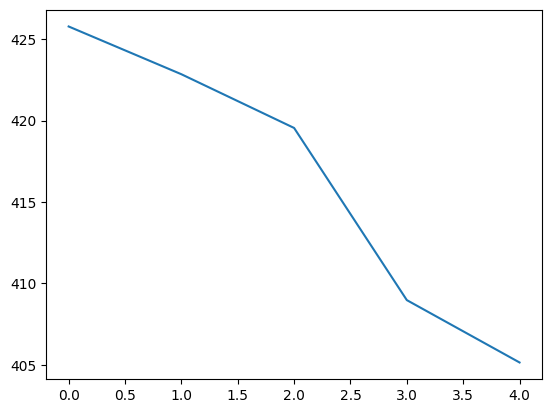

In [328]:
# for l in range(0, len(loss_list)):
#   loss_list[l] = float(loss_list[l])
plt.plot(range(0, len(loss_list)), loss_list)

In [247]:
print(output_token_label_table)

{'begin': 0, 0: 'begin', 'm': 1, 1: 'm', 't': 2, 2: 't', 'W': 3, 3: 'W', 'G': 4, 4: 'G', 'R': 5, 5: 'R', '!': 6, 6: '!', 'J': 7, 7: 'J', 'H': 8, 8: 'H', 'U': 9, 9: 'U', '?': 10, 10: '?', 'k': 11, 11: 'k', 'y': 12, 12: 'y', '2': 13, 13: '2', 'P': 14, 14: 'P', 'padding': 15, 15: 'padding', 'u': 16, 16: 'u', 'S': 17, 17: 'S', 'I': 18, 18: 'I', 'r': 19, 19: 'r', '4': 20, 20: '4', 'h': 21, 21: 'h', 'O': 22, 22: 'O', 'T': 23, 23: 'T', 'F': 24, 24: 'F', 'a': 25, 25: 'a', '"': 26, 26: '"', '—': 27, 27: '—', 'N': 28, 28: 'N', '6': 29, 29: '6', 'e': 30, 30: 'e', 'A': 31, 31: 'A', 'o': 32, 32: 'o', '3': 33, 33: '3', 'v': 34, 34: 'v', '1': 35, 35: '1', 'n': 36, 36: 'n', 'i': 37, 37: 'i', 'b': 38, 38: 'b', 'd': 39, 39: 'd', "'": 40, 40: "'", 's': 41, 41: 's', 'l': 42, 42: 'l', 'C': 43, 43: 'C', 'Y': 44, 44: 'Y', ' ': 45, 45: ' ', '.': 46, 46: '.', 'E': 47, 47: 'E', 'B': 48, 48: 'B', 'V': 49, 49: 'V', 'L': 50, 50: 'L'}


In [297]:
# model = TransformerModel(embedding_dim, n_heads).to(device)

def Translate(input_text):
    model.eval()
    text_L = len(input_text) + 1
    test_input = torch.ones(1, sequence_len, embedding_dim) * input_embedding_table["padding"]
    test_output = torch.ones(1, sequence_len, embedding_dim) * output_embedding_table["padding"]

    test_input[0, 1 : text_L] = torch.stack([input_embedding_table[token] for token in input_text])

    test_input[0, 0] = input_embedding_table["begin"]
    test_output[0, 0] = output_embedding_table["begin"]

    print(test_input.shape)

    res = ""
    for i in range(sequence_len-1):
        print(i, i)
        source_mask = GenEncoderMask(1, sequence_len, embedding_dim, n_heads, [text_L]).to(device)
        target_mask = GenDecoderMask(1, sequence_len, embedding_dim, n_heads, [i+1]).to(device)
        cross_mask = GenEncoderDecoderCrossMask(1, sequence_len, embedding_dim, n_heads, [text_L], [i+1]).to(device)

        predict_probability = model(test_input.to(device), test_output.to(device), source_mask, target_mask, cross_mask)[0][-1]
        token_index = int(torch.argmax(predict_probability))
        if (token_index == output_token_label_table['end']):
              return res

        print(token_index)
        token = output_token_label_table[token_index]
        test_output[0, i+1] = output_embedding_table[token]
        res += str(token)


    return res

aaa = train_input[7]
print(aaa)
print(train_output[1])
result = Translate(aaa)
print(result)
print(len(result))


--Non.
Emma!"
torch.Size([1, 7, 256])
0 0
41
1 1
s
1


In [186]:
print(len(output_token_label_table))

102


In [325]:
predict_probability = torch.rand(10, 6, 51)
target_probability = torch.rand(10, 6)
criterion = nn.CrossEntropyLoss(reduction='none')
loss = criterion(predict_probability.permute(0, 2, 1).float(), target_probability.long())
print(loss.sum() / 60)
criterion = nn.CrossEntropyLoss()
loss = criterion(predict_probability.permute(0, 2, 1).float(), target_probability.long())
print(loss)

tensor(3.9982)
tensor(3.9982)
